In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

Following <a ref="http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/">MCMC for Dummies</a>  
Lets generate some data: 100 points from a normal centered around zero. Our goal will be to estimate the posterior of the mean mu (we'll assume that we know the standard deviation to be 1).

In [2]:
data = np.random.randn(20)

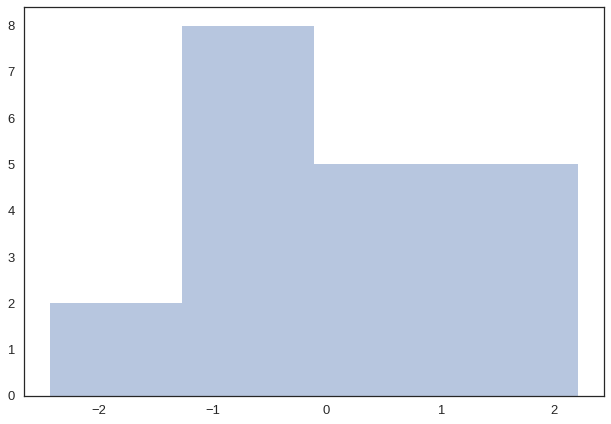

In [3]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax = ax)

For each parameter we want to infer, we have to chose a prior. For simplicity, lets also assume a Normal distribution as a prior for $\mu$. Thus, in stats speak our model is:  
$\mu \sim  Normal(0,1)$  
$x|\mu \sim Normal(x;\mu,1)$

In [4]:

def calc_posterior_analytical(data, x, mu_0, sigma_0):
    #data - samples from distribution
    #mu_0 and sigma_0 are the parameters of our prior
    #that is, the likely value of the actual mean is described by Norm(mu; mu_0, sigma_0)
    #X ~ N(x; Mu, sigma=1) and where mu is uncertain with distribution of likely values
    #Mu ~ N(mu, mu_0, sigma_0)
    sigma = 1.
    n = len(data)

    #The posterior values for the distribution (can be looled up on wikipedia)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

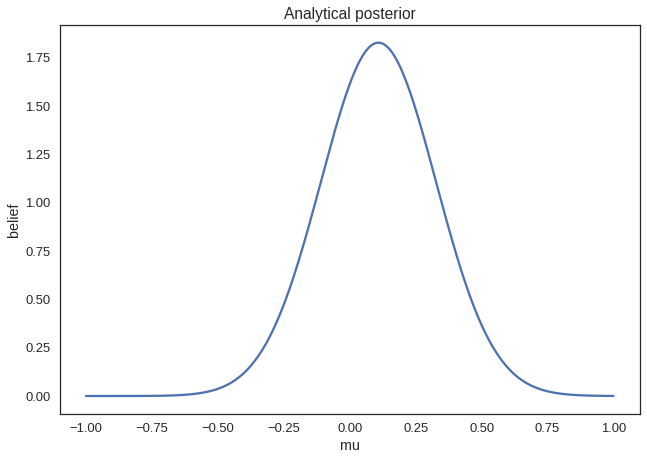

In [5]:
ax = plt.subplot()
#cool function, an array of five hundred points between -1 and 1
x = np.linspace(-1,1,500)

#generate a normal function, with mean and standard deviation
mean=2
std=0.1
simpleNorm = norm(mean, std)
#the pdf() function, is literally the probability distribution function for the defined normal
simpleNormYs = simpleNorm.pdf(x)

#OK, back to the MCMC tutorial
#Note, this is the pdf of the liklihood of the mean, given the new data.   Our estimate for the new mean is the 
#maximum of this function.  Literally the maximum liklihood estimate
mu_prior = 0.0
sigma_prior = 1.0
posterior_analytical = calc_posterior_analytical(data, x, mu_prior, sigma_prior)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior')

## Explaining MCMC sampling with code ##  

Now on to the sampling logic. At first, you find starting parameter position (can be randomly chosen), lets fix it arbitrarily to:

In [6]:
mu_current=1

Then, you propose to move (jump) from that position somewhere else (that's the Markov part). You can be very dumb or very sophisticated about how you come up with that proposal. The Metropolis sampler is very dumb and just takes a sample from a normal distribution (no relationship to the normal we assume for the model) centered around your current mu value (i.e. mu_current) with a certain standard deviation (proposal_width) that will determine how far you propose jumps (here we're use scipy.stats.norm):

In [7]:
proposal_width = 2

#the rvs() function generates samples from the given distribution
mu_prop = norm(mu_current, proposal_width).rvs(size=1)

Next, you evaluate whether that's a good place to jump to or not. **If the resulting normal distribution with that proposed mu explaines the data better than your old mu, you'll definitely want to go there**. 

What does "explains the data better" mean? *We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed mu and a fixed sigma = 1)*. 

This can easily be computed by calculating the probability for each data point using scipy.stats.normal(mu, sigma).pdf(data) and then multiplying the individual probabilities, i.e. compute the likelihood (**usually you would use log probabilities but we omit this here**):

Lets make some nomenclature clear
I have a set of samples $X$, drawn from a distribution $P(x; \mu_T, \sigma_T) ~ \sim N(x; \mu_T, \sigma_T)$  
Of course, I don't know $\mu_T$, lets assume that I do know $\sigma_T$, but I have some prior distribution describing the liklihood of values it could be

$\mu_T \sim N(\mu; \mu_{\mu}, \sigma_{\mu})$   $\leftarrow$ this guy is my prior  
For $\mu_{\mu}$, and $\sigma_{\mu}$ I'll  have to take an initial guess

Thus, I want to take samples from $P(\mu | X)$, which is the updated version of my prior, after the incorporation of information in the samples $X$, so that I can estimate it (recall, we use MCMC when we can't analytically determine $P(\mu | X)$).

$P(\mu | X) = \frac{P(X | \mu_{curr})*N(\mu_{curr}; \mu_{\mu}, \sigma_{\mu})}{P(X)}$

Now I can choose another propsed value for $\mu$, $\mu_{prop}$, and check if was more likely to create my observed data $X$ than my current estimate for $\mu = \mu_{curr}$.   I guess we don't use our prior to draw $\mu_{prop}$ because our prior might be pretty shitty? 

In [8]:
#recall here, that we are assuming that we already know the standard deviation of the distribution, and are only
#estimating the mean
liklihood_current = norm(mu_current, 1.0).pdf(data).prod()

#liklihood of our new estimate
liklihood_proposal = norm(mu_prop, 1.0).pdf (data).prod()

#probability of get our mu_current from our prior distribution
prior_current = norm(mu_prior, sigma_prior).pdf(mu_current)

#probability of get our mu_current from our prior distribution
prior_prop = norm(mu_prior, sigma_prior).pdf(mu_prop)

#Nominator of Bayes Formula
p_current =  liklihood_current*prior_current
p_prop = liklihood_proposal*prior_prop


The liklihood ratio (how likely $\mu_{curr}$ is compared to $\mu_{prop}$) is given by

$\frac{P(\mu_{prop} | X)}{P(\mu_{curr} | X)} = \frac{P(X | \mu_{prop})*N(\mu_{prop}; \mu_{\mu}, \sigma_{\mu})}{P(X | \mu_{curr})*N(\mu_{curr}; \mu_{\mu}, \sigma_{\mu})}$  

Ok, from this point out, I assume that you'll need to understand more of the theory of MCMC for this to make sense, so what follows is more of a plausibility argument.  

We are going to take a random walk that is driven by both our samples, and our prior distribution. $\mu_{prop}$ is a proposed step in that walk.  We take the step if $\frac{P(\mu_{prop} | X)}{P(\mu_{curr} | X)}$ is greater than a random draw from a uniform distribution between 0 and 1.  That is


if ($\frac{P(\mu_{prop} | X)}{P(\mu_{curr} | X)}$ > random( )) {  
&nbsp; accept($\mu_{prop}$)  
} else {  
&nbsp; reject($\mu_{prop}$)  
}  

If we accept $\mu_{prop}$, we add it to our samples, and use it as the starting point for our next step  
$\mu_{curr} = \mu_{prop}$  

**Consider the following**
* Intuitively, something like the random threshold is necessary as we want samples from a distribution if we didn't have the random threshold we would monatonically towards the $\mu_{prop}$ with the highest liklihood
* The fact that our steps are predjudiced towards those that have large $\frac{P(\mu_{prop} | X)}{P(\mu_{curr} | X)}$ (recall $\frac{P(\mu_{prop} | X)}{P(\mu_{curr} | X)} > 1$ is automatically chosen), means that we draw most of our samples in the regions where the posterior would be largest, which is what we expect from the correct answer (like I said, not a proof, more of a plausibility argument)


*** The question then is why does this converge to or approximate samples from the posterior distribution ***

In [9]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()

The first columns is our prior distribution -- what our belief about $\mu$ is before seeing the data. You can see how the distribution is static and we only plug in our μμ proposals. The vertical lines represent our current μμ in blue and our proposed $\mu$ in either red or green (rejected or accepted, respectively).

The 2nd column is our likelihood and what we are using to evaluate how good our model explains the data. You can see that the likelihood function changes in response to the proposed $\mu$. The blue histogram which is our data. The solid line in green or red is the likelihood with the currently proposed $\mu$. Intuitively, the more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dotted line of the same color is the proposed mu and the dotted blue line is the current mu.

The 3rd column is our analytic posterior distribution. Here I am displaying the normalized posterior but as we found out above, we can just multiply the prior value for the current and proposed $\mu$'s by the likelihood value for the two $\mu$'s to get the unnormalized posterior values (which we use for the actual computation), and divide one by the other to get our acceptance probability.

The 4th column is our trace (i.e. the posterior samples of μ we're generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that we always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values, as can be seen in iteration 14 (the iteration number can be found at the top center of each row).  

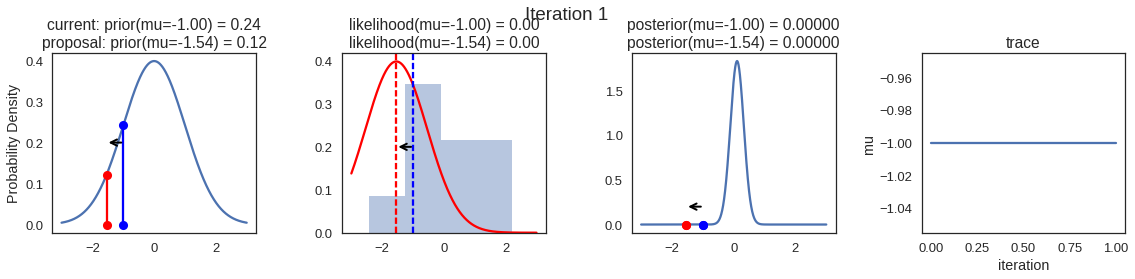

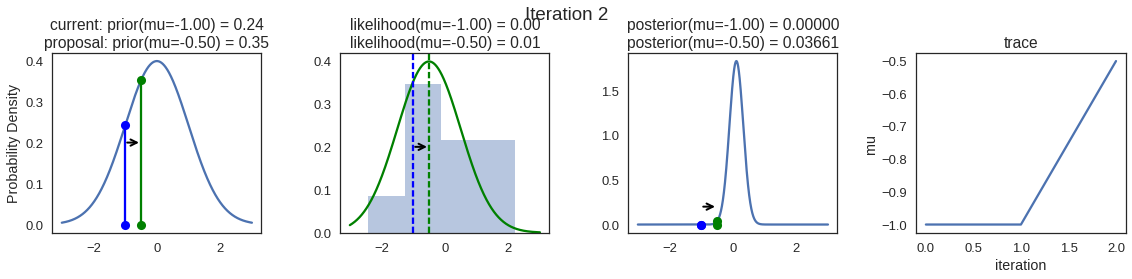

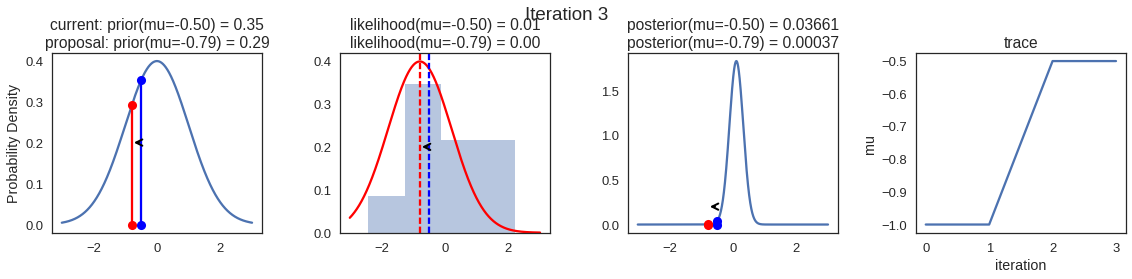

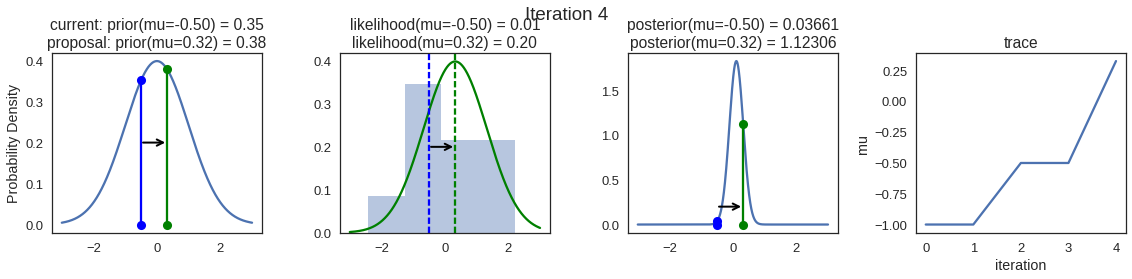

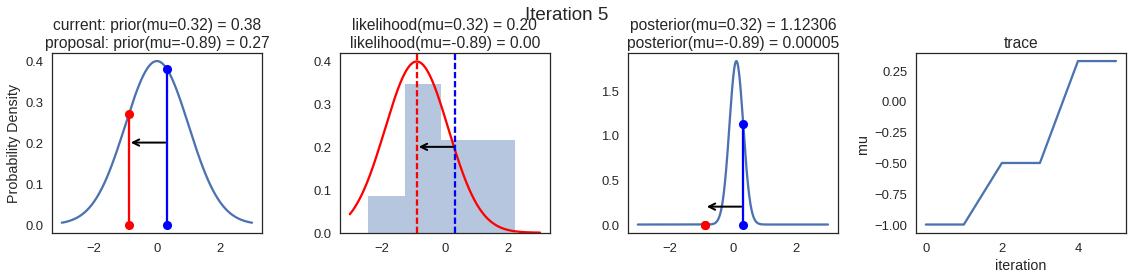

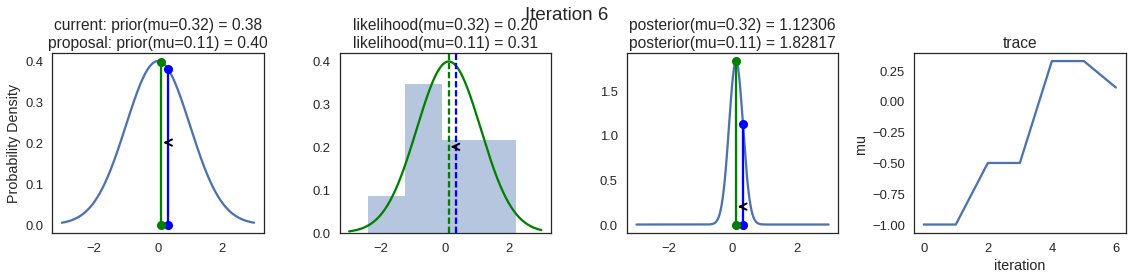

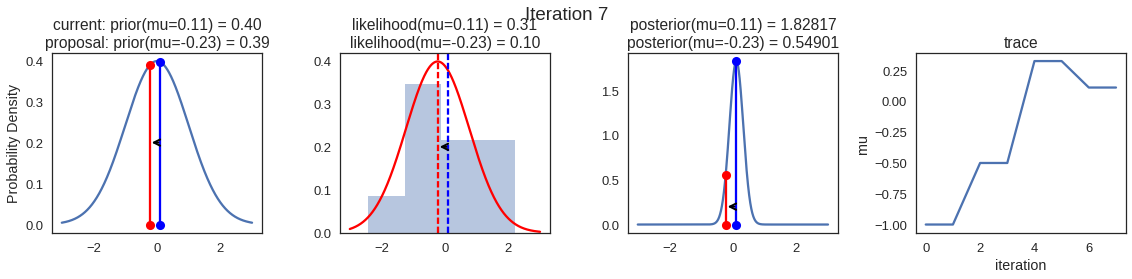

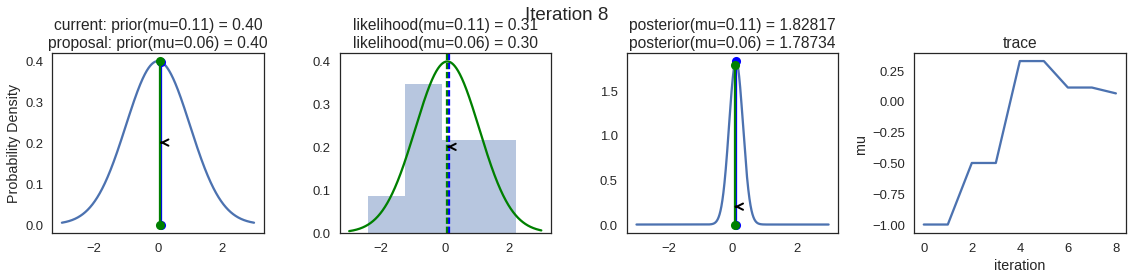

In [10]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

These samples (the trace) are samples from the prior distribution.   To see this lets generate some samples

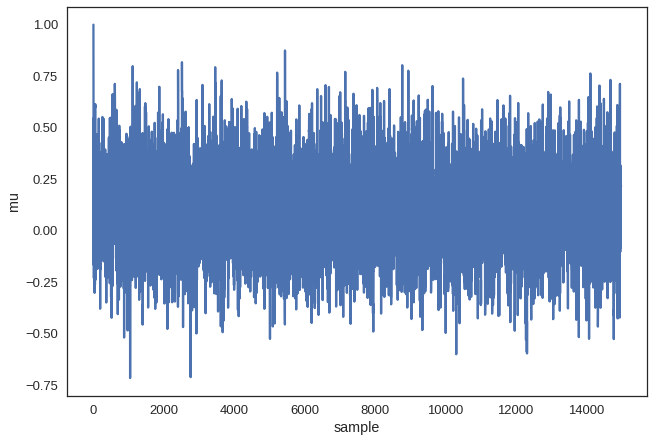

In [11]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

Taking a histogram to get a sense of the distribution we are sampling from.


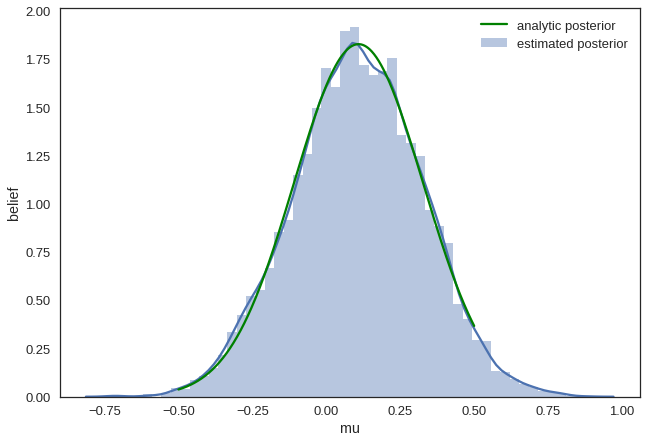

In [12]:
ax = plt.subplot()

#Here he sliced off the first 500 samples from the posterior.  
#Perhaps it takes a while to converge to the posterior?
sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

## Proposal Width ##  

Recall the proposal width was the width of the guassian around the current $\mu$ from which we chose the proposal. Above we set the proposal width to 0.5. That turned out to be a pretty good value. In general you don't want the width to be too narrow because your sampling will be inefficient as it takes a long time to explore the whole parameter space and shows the typical random-walk behavior:

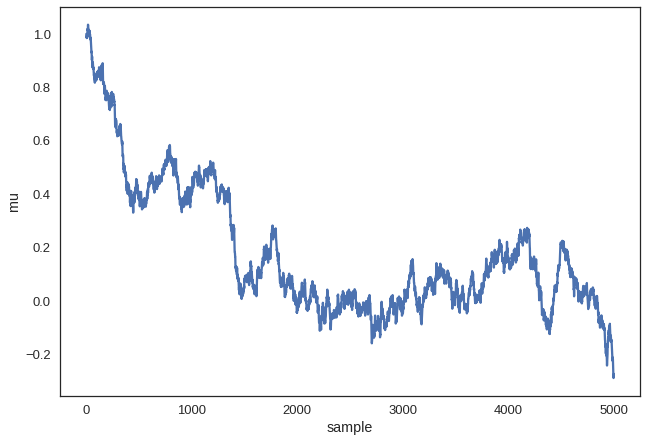

In [13]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

It's going to take a long time for this to fully sample the posterior.  Similary you don't want the proposal width to be so large that all proposed changes are rejected.

CPU times: user 19 s, sys: 32 ms, total: 19.1 s
Wall time: 19.2 s


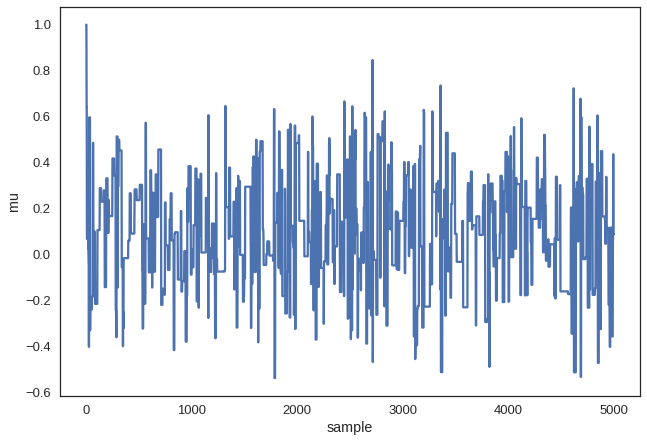

In [14]:
%time posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

With more samples this will eventually look like the true posterior. The key is that we want our samples to be independent of each other which cleary isn't the case here. Thus, one common metric to evaluate the efficiency of our sampler is the autocorrelation -- i.e. how correlated a sample i is to sample i-1, i-2, etc:

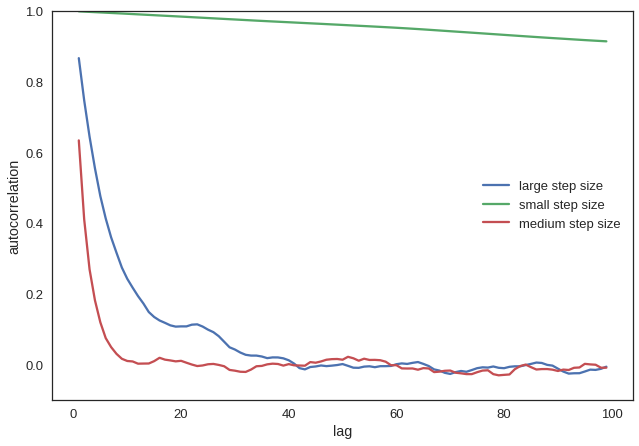

In [15]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [autocorr(posterior_large, l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(posterior_small, l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(posterior, l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))